AutoEncoder

In [16]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

batchsize = 128
epochs=10
loginterval=10

SEED = 1
torch.manual_seed(SEED)


kwargs = {'num_workers': 4, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # create using nn.Sequential()
        # encoder :FC (784 -> 400), RELU activation; FC (400, 20)
        # decoder :FC (20 -> 400), RELU activation; FC (400, 784)
        self.encoder = nn.Sequential(
                nn.Linear(784, 400),
                nn.ReLU(),
                nn.Linear(400, 20),
                )
        self.decoder = nn.Sequential(
                nn.Linear(20, 400),
                nn.ReLU(),
                nn.Linear(400, 784),
                )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        xview = x.view(-1,784)
        z = self.encode(xview)
        return self.decode(z)

model = AE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
def loss_function(recon_batch, x):
    #compute bce as the bin0ary cross entropy across the batch as a sum
    bce = nn.BCELoss(size_average=False)
    return bce(recon_batch, x)

In [19]:
losses = []
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784))
        losses.append(loss.cpu().item())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % loginterval == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.1f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), end='')

    print(' Average loss: {:.1f}'.format(
          train_loss / len(train_loader.dataset)), end='')

In [24]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += loss_function(recon_batch, data.view(-1, 784))

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batchsize, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '/home/mberrada/results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(' Test loss: {:.1f}'.format(test_loss))

In [28]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
     sample = torch.randn(64, 20).to(device)
     sample = model.decode(sample).cpu()
     save_image(sample.view(64, 1, 28, 28), '/home/mberrada/results/sample_' + str(epoch) + '.png')

 Train Epoch: 1 [58880/60000 (98%)]	Loss: 69.9 Average loss: 66.8 Test loss: 66.9
 Train Epoch: 2 [58880/60000 (98%)]	Loss: 66.4 Average loss: 66.5 Test loss: 66.6
 Train Epoch: 3 [58880/60000 (98%)]	Loss: 64.6 Average loss: 66.3 Test loss: 66.5
 Train Epoch: 4 [58880/60000 (98%)]	Loss: 66.9 Average loss: 66.1 Test loss: 66.2
 Train Epoch: 5 [58880/60000 (98%)]	Loss: 67.8 Average loss: 65.9 Test loss: 66.1
 Train Epoch: 6 [58880/60000 (98%)]	Loss: 67.3 Average loss: 65.7 Test loss: 66.1
 Train Epoch: 7 [58880/60000 (98%)]	Loss: 65.8 Average loss: 65.5 Test loss: 65.9
 Train Epoch: 8 [58880/60000 (98%)]	Loss: 64.6 Average loss: 65.4 Test loss: 65.7
 Train Epoch: 9 [58880/60000 (98%)]	Loss: 64.0 Average loss: 65.2 Test loss: 65.6
 Train Epoch: 10 [58880/60000 (98%)]	Loss: 68.1 Average loss: 65.1 Test loss: 65.6


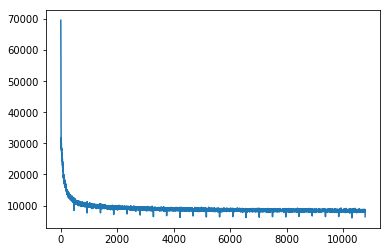

In [33]:
#plot losse
plt.plot(losses)